In [53]:
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt

In [743]:
import numpy as np
from scipy.integrate import dblquad, quad
from scipy.special import jv

### Kernels

def K_based(x1, x2, b):
    rho = np.sqrt((x2 - x1)**2 + b **2)
    cos_theta = b / rho
    #return -0.5j * np.exp(2.j * np.pi * rho) / rho * (1 + cos_theta)
    return -1.j * np.exp(2.j * np.pi * rho) / rho * cos_theta

def K_rect_plane(x1, x2, b):
    return (1. + 1.j) / np.sqrt(2 * b) * \
            np.exp(-1.j * np.pi * np.square(x2 - x1) / b)

def K_circular_plane(x1, x2, b, n):
    return 1.j ** (n + 1) * 2 * np.pi / b * \
            jv(n, 2 * np.pi / b * x1 * x2) * \
            np.sqrt(x1 * x2) * \
            np.exp(-1.j * np.pi * (x1 ** 2 + x2 ** 2) / b)

def K_confocal_spherical(x1, x2, b, n):
    return 1.j ** (n + 1) * 2 * np.pi / b * \
            jv(n, 2 * np.pi / b * x1 * x2) * \
            np.sqrt(x1 * x2)

### Integrating

IFP_types = ['rect', 'circ', 'sphere']

def integrate(a, b, type, n: int = 10, iters=100, init_phase=None, order=None, norm=None, scale: bool =True):
    '''
        ToDO: 
        Full description of function
    '''

    kwarg = {'b' : b}

    ### configure kernel for equation
    match type:
        case 'rect':
            Kernel = K_rect_plane
            diaposon = np.linspace(-a, a, n)
        case 'circ':
            if order is None:
                raise ValueError(f'In {type} type of IFP expected an order of solution (variable n)')
            Kernel = K_circular_plane
            kwarg['n'] = order
            diaposon = np.linspace(0, a, n)
        case 'sphere':
            if order is None:
                raise ValueError(f'In {type} type of IFP expected an order of solution (variable n)')
            Kernel = K_confocal_spherical
            kwarg['n'] = order
            diaposon = np.linspace(0, a, n)
        case 'based':
            Kernel = K_based
            diaposon = np.linspace(-a, a, n)
        case _:
            raise ValueError(f'No match for {type}. Expected { {*IFP_types} }')
        
    if init_phase is None:
        init_phase = np.ones(n, dtype=np.complex128)

    V_prev = init_phase
    V_current = np.zeros(n, dtype=np.complex128)

    result = []

    ### solve equation
    for _ in range(iters):
        for k in range(n):
            V_current[k] = np.trapz(
                Kernel(diaposon[k], diaposon, **kwarg) * V_prev, diaposon
            )

        if norm is not None:
            for vec in norm:
                V_current -= np.sum(vec * V_current) / np.sum(vec ** 2) * vec

        if scale:
            V_current /= V_current[np.argmax(np.abs(V_current))]

        result.append(np.copy(V_current))
        
        V_prev = np.copy(V_current)

    return np.array(result)

In [98]:
a = 25
n = 500

res = integrate(
    a = a,
    b = 100,
    type='rect',
    n=n,
    iters=300)

x = np.linspace(0, a, n // 2)

### Построить

- TEM1 для прямоугольного (фмплитуда + фаза), зоны: 6.25, 1, 0.1
- Круглые распределение (ампл + фаза) зоны: 6.25, 1, 0.1
- Круглые TEM1 (ампл + фаза)

## Прямоугольник

---

### Итерации

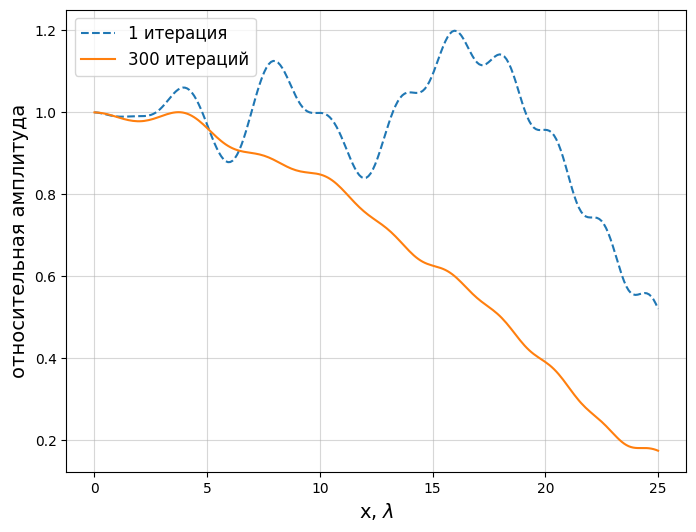

In [112]:
plt.figure(figsize=(8, 6))

plt.plot(x, np.abs(res)[0,n//2:], linestyle='--', label='1 итерация')
plt.plot(x, np.abs(res)[-1,n//2:], label='300 итераций')
plt.grid(alpha=.5)
plt.legend(fontsize=12)

plt.xlabel('x, $\lambda$', fontsize=14)
plt.ylabel('относительная амплитуда', fontsize=14)

plt.show()

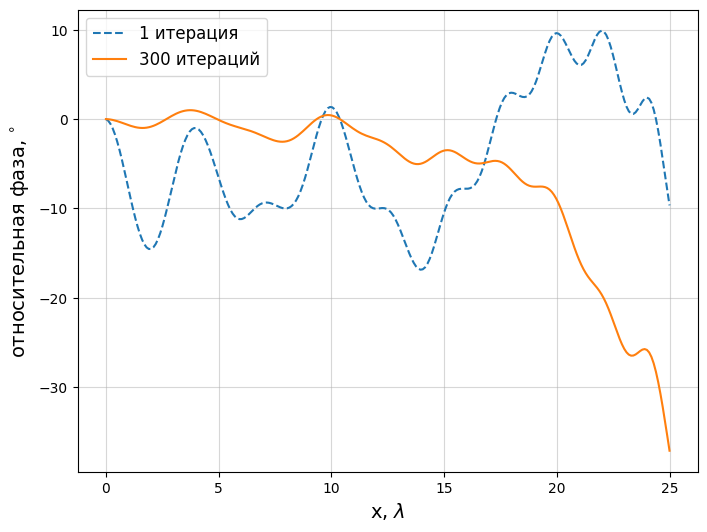

In [113]:
plt.figure(figsize=(8, 6))

plt.plot(x, np.rad2deg(np.angle(res))[0,n//2:], linestyle='--', label='1 итерация')
plt.plot(x, np.rad2deg(np.angle(res))[-1,n//2:], label='300 итераций')
plt.grid(alpha=.5)
plt.legend(fontsize=12)

plt.xlabel('x, $\lambda$', fontsize=14)
plt.ylabel(r'относительная фаза, $^{\circ}$', fontsize=14)

plt.show()

---

### По координате

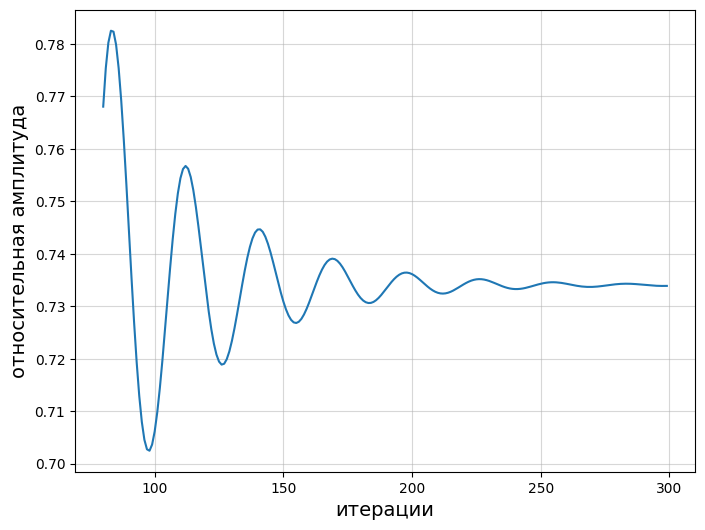

In [117]:
plt.figure(figsize=(8, 6))

plt.plot(range(80, 300), np.abs(res)[80:,- n // 4])

plt.grid(alpha=.5)

plt.xlabel('итерации', fontsize=14)
plt.ylabel(r'относительная амплитуда', fontsize=14)

plt.show()

---

### варифция зон Френеля

In [167]:
zones = [0.5, 2.5, 6.25]

ampl, phase = [], []

for z in zones:
    res = integrate(
        a = 25,
        b = 625 / z,
        n = 500,
        iters=100,
        type='rect'
    )
    ampl.append(np.abs(res))
    phase.append(np.rad2deg(np.angle(res)))

x = np.linspace(0, 25, 250)

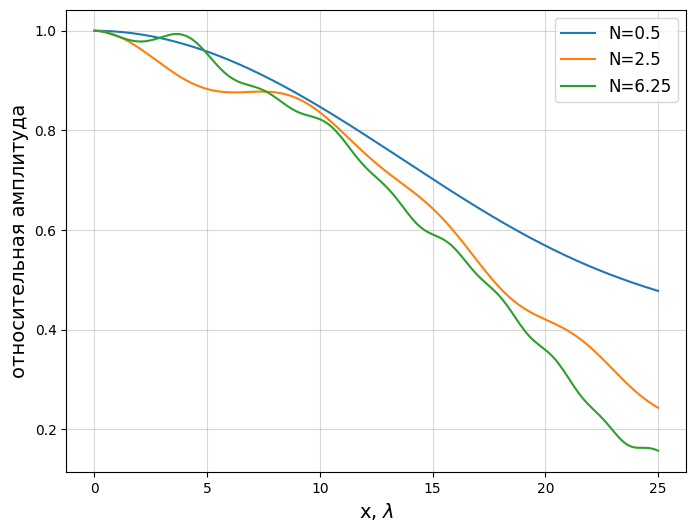

In [168]:
plt.figure(figsize=(8,6))

for z, a in zip(zones, ampl):
    plt.plot(x, a[-1,250:], label=f'N={z}')

plt.legend(fontsize=12)

plt.grid(alpha=.5)

plt.xlabel('x, $\lambda$', fontsize=14)
plt.ylabel('относительная амплитуда', fontsize=14)

plt.show()

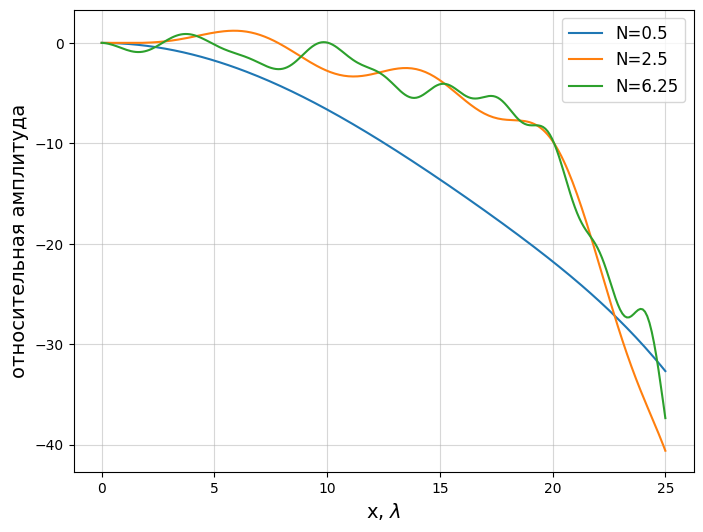

In [169]:
plt.figure(figsize=(8,6))

for z, p in zip(zones, phase):
    plt.plot(x, p[-1,250:], label=f'N={z}')

plt.legend(fontsize=12)

plt.grid(alpha=.5)

plt.xlabel('x, $\lambda$', fontsize=14)
plt.ylabel('относительная амплитуда', fontsize=14)

plt.show()

## Тестируем базируванную формулу

---

### распределение

In [162]:
zones = [0.5, 2.5, 6.25]

ampl, phase = [], []

for z in zones:
    res = integrate(
        a = 25,
        b = 625 / z,
        n = 250,
        iters=300,
        type='based'
    )
    ampl.append(np.abs(res))
    phase.append(np.rad2deg(np.angle(res)))

x = np.linspace(0, 25, 125)

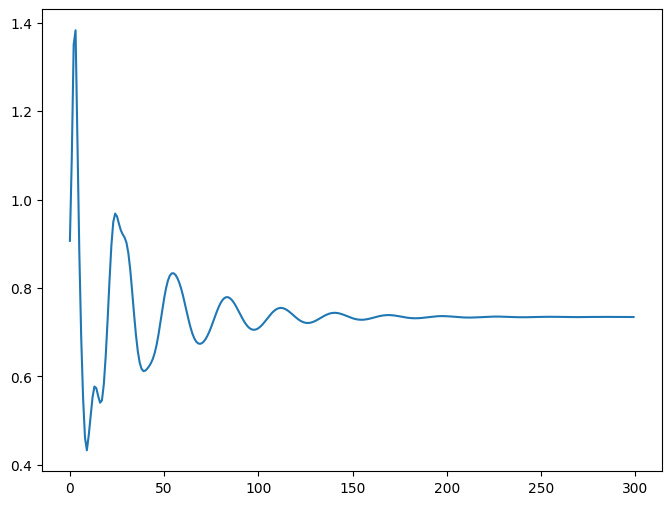

In [163]:
plt.figure(figsize=(8,6))

plt.plot(ampl[2][:,187])

plt.show()

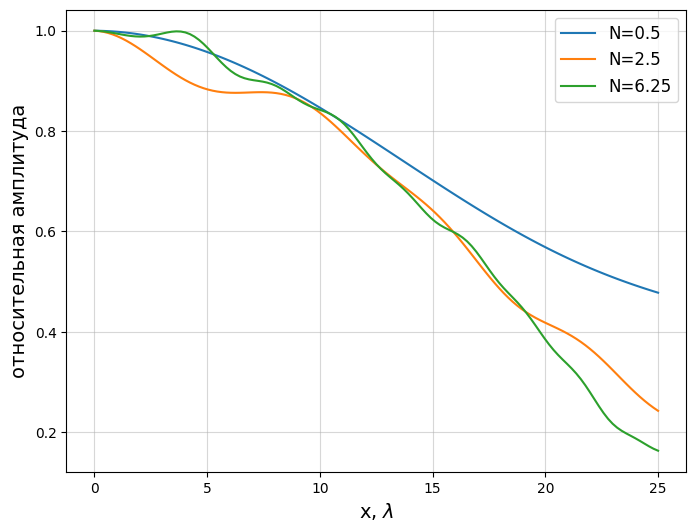

In [164]:
plt.figure(figsize=(8,6))

for z, a in zip(zones, ampl):
    plt.plot(x, a[-1,125:], label=f'N={z}')

plt.legend(fontsize=12)

plt.grid(alpha=.5)

plt.xlabel('x, $\lambda$', fontsize=14)
plt.ylabel('относительная амплитуда', fontsize=14)

plt.show()

In [134]:
1 / np.arctan(1/4)

4.081988150462483

## Сферическое

---

### Распределение

In [240]:
a = 25
n = 100

phi = np.linspace(np.pi, 0, n)

p = np.exp(1.j * phi)

res = integrate(
    a = a,
    b = a**2 / 3,
    type='circ',
    n=n,
    order=1,
    iters=300)
    #init_phase=p)

x = np.linspace(0, a, n)

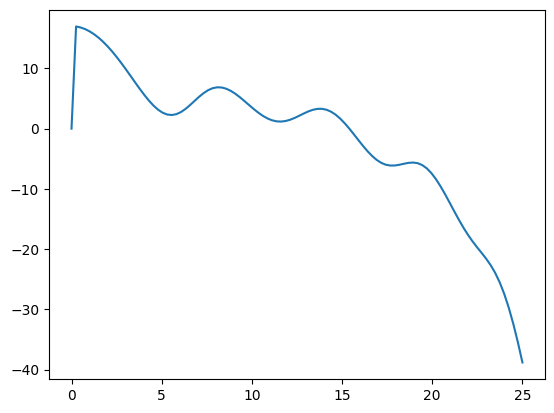

In [241]:
plt.plot(x, np.rad2deg(np.angle(res))[-1])

/tmp/ipykernel_857/970274407.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(x, np.abs(res / np.sqrt(x))[-1])


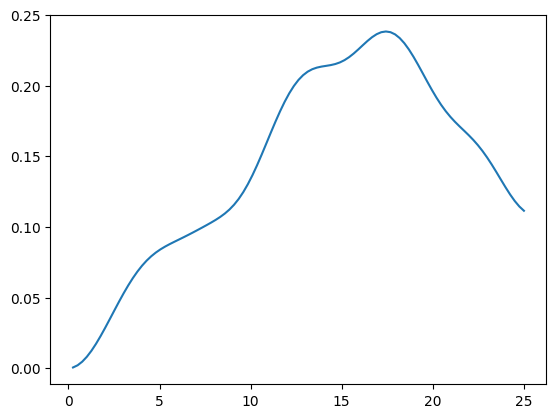

In [237]:
plt.plot(x, np.abs(res / np.sqrt(x))[-1])

### эксперименты

In [324]:
a = 25
n = 200

p = np.ones(n, dtype=np.complex128)
#p[n * 2 // 3:n * 4 // 3] = 1
p[n//2:] *= -1

res = integrate(
    a=a,
    b=a**2 / 0.5,
    n=n,
    iters=300,
    init_phase=p,
    type='sphere',
    order=2
)

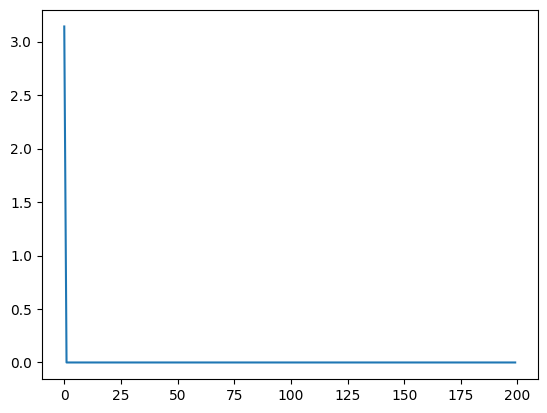

In [325]:
#plt.plot(np.angle(res[-1] * np.exp(1.j * np.pi / 4)))
plt.plot(np.angle(res[-1]))

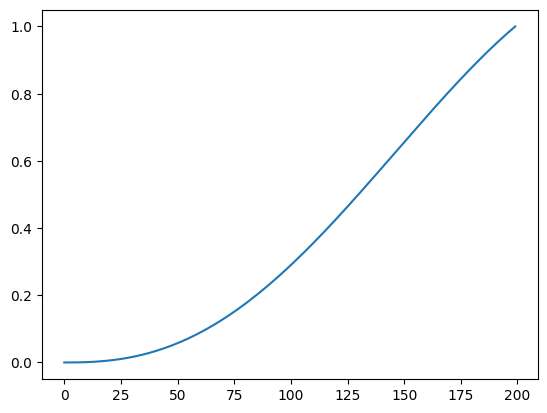

In [326]:
plt.plot(np.abs(res[-1]))

---

### Тестим базис

In [403]:
17.365269461077844 * 3

52.09580838323353

In [450]:
a = 55
b = 100
n = 100

In [458]:
TEM_0 = integrate(
    a=a,
    b=b,
    n=2 * n + 1,
    iters=500,
    type='rect'
)[-1]

In [459]:
v = np.ones(2 * n + 1, dtype=np.complex128)

proj = np.sum(v * TEM_0) / np.sum(TEM_0 ** 2)

In [460]:
v -= proj * TEM_0

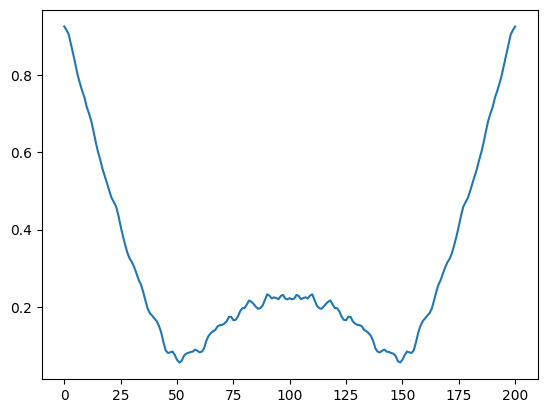

In [461]:
plt.plot(np.abs(v))

In [578]:
res = integrate(
    a=a,
    b=b,
    n=2 * n + 1,
    type='rect',
    init_phase=v,
    norm=[TEM_0, TEM_1],
    iters=1500
)

In [579]:
TEM_2 = res[-1]

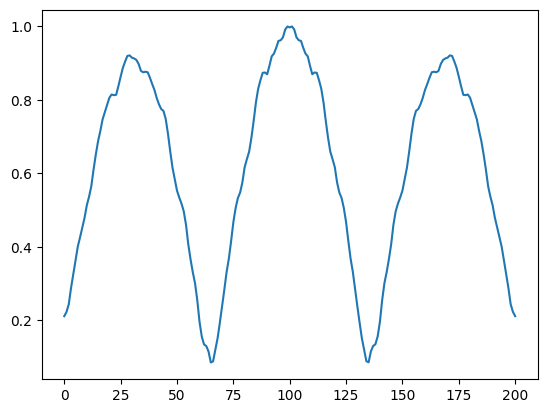

In [580]:
plt.plot(np.abs(res[-1]))

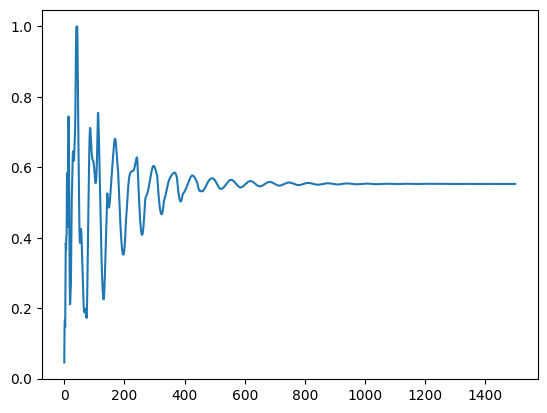

In [581]:
plt.plot(np.abs(res[:,150]))

### 1 и 3 гармоники

In [573]:
p = np.ones(2 * n + 1, dtype=np.complex128)
p[:n] *= -1

TEM_1 = integrate(
    a=a,
    b=b,
    n=2 * n + 1,
    type='rect',
    iters=1500,
    init_phase=p,
    norm=[TEM_0]
)

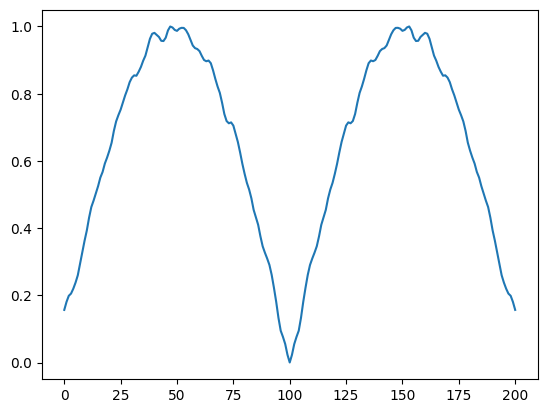

In [574]:
plt.plot(np.abs(TEM_1[-1]))

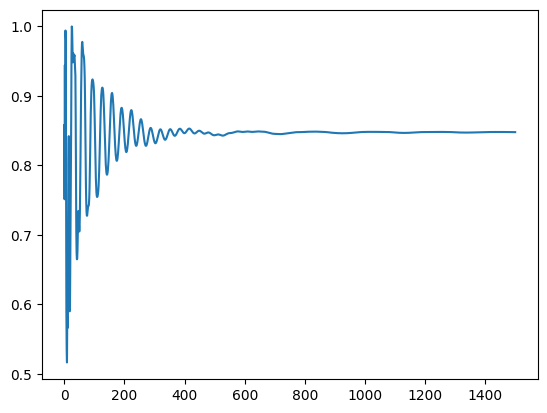

In [575]:
plt.plot(np.abs(TEM_1[:,30]))

In [577]:
TEM_1 = TEM_1[-1]

In [597]:
v = np.ones(2 * n + 1, dtype=np.complex128)
v[:n] *= -1

TEM_3 = integrate(
    a=a,
    b=b,
    n=2*n+1,
    type='rect',
    norm=[TEM_0, TEM_1, TEM_2],
    iters=2000,
    init_phase=v
)

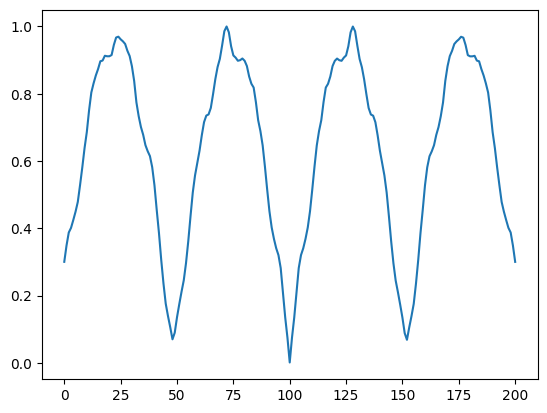

In [598]:
plt.plot(np.abs(TEM_3[-1]))

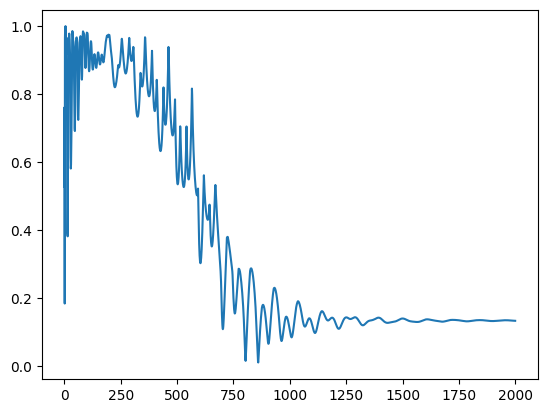

In [599]:
plt.plot(np.abs(TEM_3[:,150]))

In [584]:
v = np.ones(2 * n + 1, dtype=np.complex128)

TEM_4 = integrate(
    a=a,
    b=b,
    n=2*n+1,
    type='rect',
    norm=[TEM_0, TEM_1, TEM_2],
    iters=1000
)

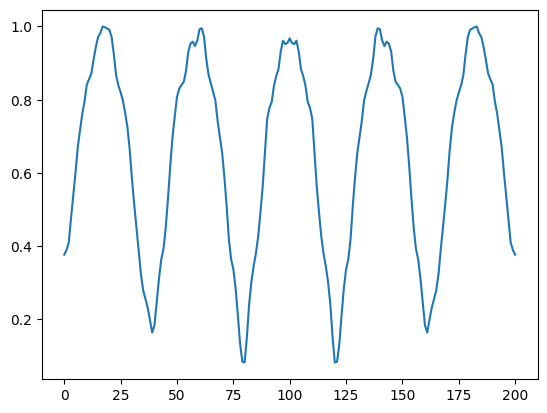

In [585]:
plt.plot(np.abs(TEM_4[-1]))

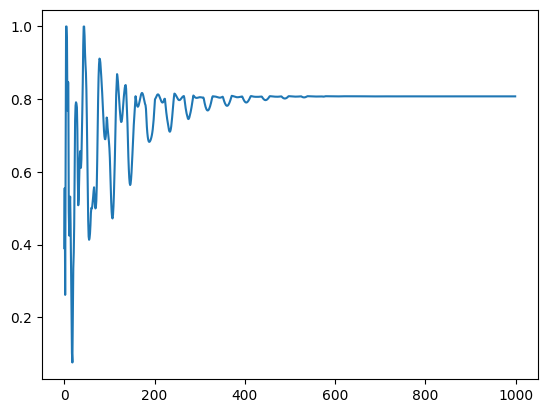

In [586]:
plt.plot(np.abs(TEM_3[:,150]))

### Построение гармоник

In [769]:
class TEM_constructor:
    def __init__(self, a, b, type, n):
        self.a = a
        self.b = b
        self.type = type
        self.n = n
        self.modes = -1
        self.TEM = []
        self.history = []

    def calculate_next_mode(self, iters: int):
        init_phase = np.ones(self.n, dtype=np.complex128)
        #if self.modes == 0: # рассчет моды TEM-1
        if self.modes % 2 == 0: # генерация нечетных мод
            init_phase[self.n // 2:] *= -1

        print(f'Calculating {self.modes+1} mode...')

        res = integrate(
            a=self.a,
            b=self.b,
            type=self.type,
            n=self.n,
            iters=iters,
            init_phase=init_phase,
            norm=self.TEM
        )

        print('Calculated')

        self.history.append(res)
        self.TEM.append(res[-1])
        self.modes += 1

    def damp_factor(self, k: int, iters: int = 1):
        if k < 0 or k > self.modes:
            raise IndexError(f'Do not have {k} mode')
        
        x = self.TEM[k]
        y = integrate(
            a=self.a,
            b=self.b,
            type=self.type,
            n=self.n,
            iters=iters,
            init_phase=x,
            scale=False
        )
        return np.sum(x ** 2) / np.sum(x * y)



    def __call__(self, k: int, iters: int):
        if k <= self.modes:
            self.modes = k - 1
            self.TEM = self.TEM[:k - 1]
            self.history = self.history[:k - 1]
        
        for _ in range(k - self.modes):
            self.calculate_next_mode(iters)

In [770]:
g = TEM_constructor(
    a=25, b=100, type='based', n=201
)

In [771]:
g(k = 3, iters = 500)

Calculating 0 mode...
Calculated
Calculating 1 mode...
Calculated
Calculating 2 mode...
Calculated
Calculating 3 mode...
Calculated


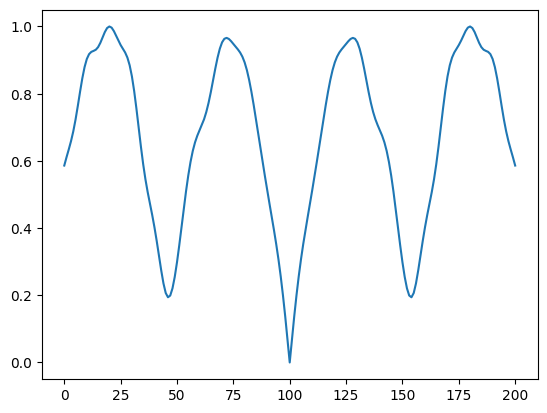

In [772]:
plt.plot(np.abs(g.TEM[3]))

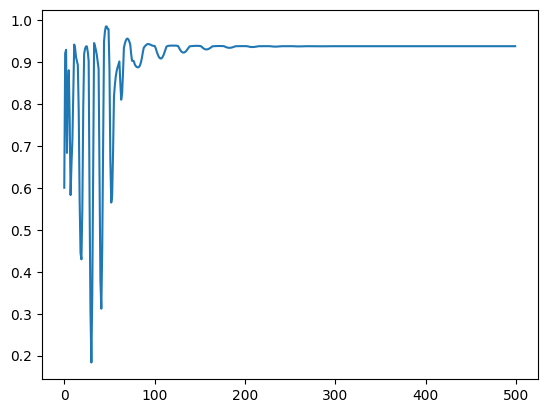

In [773]:
plt.plot(np.abs(g.history[3][:,15]))

In [778]:
[np.abs(g.damp_factor(i)) for i in range(g.modes+1)]

[10.034869030335802,
 10.138478147485454,
 10.310328098913702,
 10.601816315294462]

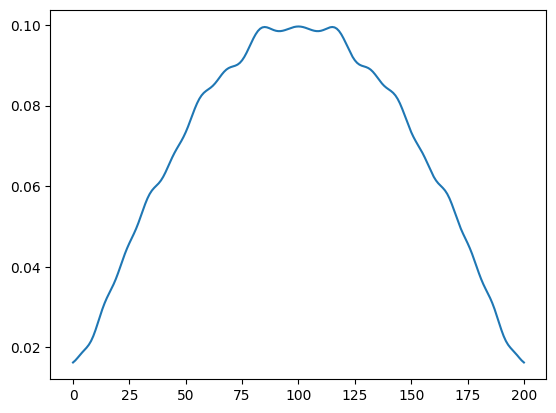

In [777]:
plt.plot(np.abs(
    integrate(
        a=g.a, b=g.b, n=g.n,
        iters=1, init_phase=g.TEM[0], scale=False, type='based'
    )[-1]
))